In [1]:
ROOT_DATA_DIR = '../NICU_Data/FirstFrameDepthRGB_origData_prePT/'
BASE_MODEL_NAME = 'vgg16_3channel'
TRAIN_DIR = ROOT_DATA_DIR + 'train/'
VAL_DIR = ROOT_DATA_DIR + 'val/'
K_FOLDS = 5
BATCH_SIZE = 16
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
CLASS_WEIGHT = None
INITIAL_BIAS = None
LEARNING_RATE = 0.00001
MOMENTUM = 0.9
FINETUNING = False

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
import shutil
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
import seaborn as sns

In [3]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
noone_p1 = glob(ROOT_DATA_DIR + 'p1/noone/*.jpg')
nurse_p1 = glob(ROOT_DATA_DIR + 'p1/nurse/*.jpg')
noone_p2 = glob(ROOT_DATA_DIR + 'p2/noone/*.jpg')
nurse_p2 = glob(ROOT_DATA_DIR + 'p2/nurse/*.jpg')
noone_p5 = glob(ROOT_DATA_DIR + 'p5/noone/*.jpg')
nurse_p5 = glob(ROOT_DATA_DIR + 'p5/nurse/*.jpg')
noone_p6 = glob(ROOT_DATA_DIR + 'p6/noone/*.jpg')
nurse_p6 = glob(ROOT_DATA_DIR + 'p6/nurse/*.jpg')
noone_p8 = glob(ROOT_DATA_DIR + 'p8/noone/*.jpg')
nurse_p8 = glob(ROOT_DATA_DIR + 'p8/nurse/*.jpg')
noone_p9 = glob(ROOT_DATA_DIR + 'p9/noone/*.jpg')
nurse_p9 = glob(ROOT_DATA_DIR + 'p9/nurse/*.jpg')
noone_p10 = glob(ROOT_DATA_DIR + 'p10/noone/*.jpg')
nurse_p10 = glob(ROOT_DATA_DIR + 'p10/nurse/*.jpg')
noone_p11 = glob(ROOT_DATA_DIR + 'p11/noone/*.jpg')
nurse_p11 = glob(ROOT_DATA_DIR + 'p11/nurse/*.jpg')
noone_p13 = glob(ROOT_DATA_DIR + 'p13/noone/*.jpg')
nurse_p13 = glob(ROOT_DATA_DIR + 'p13/nurse/*.jpg')
noone_p14 = glob(ROOT_DATA_DIR + 'p14/noone/*.jpg')
nurse_p14 = glob(ROOT_DATA_DIR + 'p14/nurse/*.jpg')
noone_p15 = glob(ROOT_DATA_DIR + 'p15/noone/*.jpg')
nurse_p15 = glob(ROOT_DATA_DIR + 'p15/nurse/*.jpg')
noone_p16 = glob(ROOT_DATA_DIR + 'p16/noone/*.jpg')
nurse_p16 = glob(ROOT_DATA_DIR + 'p16/nurse/*.jpg')
noone_p17 = glob(ROOT_DATA_DIR + 'p17/noone/*.jpg')
nurse_p17 = glob(ROOT_DATA_DIR + 'p17/nurse/*.jpg')
noone_p21 = glob(ROOT_DATA_DIR + 'p21/noone/*.jpg')
nurse_p21 = glob(ROOT_DATA_DIR + 'p21/nurse/*.jpg')
noone_p22 = glob(ROOT_DATA_DIR + 'p22/noone/*.jpg')
nurse_p22 = glob(ROOT_DATA_DIR + 'p22/nurse/*.jpg')
noone_p23 = glob(ROOT_DATA_DIR + 'p23/noone/*.jpg')
nurse_p23 = glob(ROOT_DATA_DIR + 'p23/nurse/*.jpg')
noone_p24 = glob(ROOT_DATA_DIR + 'p24/noone/*.jpg')
nurse_p24 = glob(ROOT_DATA_DIR + 'p24/nurse/*.jpg')
noone_p25 = glob(ROOT_DATA_DIR + 'p25/noone/*.jpg')
nurse_p25 = glob(ROOT_DATA_DIR + 'p25/nurse/*.jpg')
noone_p26 = glob(ROOT_DATA_DIR + 'p26/noone/*.jpg')
nurse_p26 = glob(ROOT_DATA_DIR + 'p26/nurse/*.jpg')
noone_p27 = glob(ROOT_DATA_DIR + 'p27/noone/*.jpg')
nurse_p27 = glob(ROOT_DATA_DIR + 'p27/nurse/*.jpg')
noone_p28 = glob(ROOT_DATA_DIR + 'p28/noone/*.jpg')
nurse_p28 = glob(ROOT_DATA_DIR + 'p28/nurse/*.jpg')
noone_p29 = glob(ROOT_DATA_DIR + 'p29/noone/*.jpg')
nurse_p29 = glob(ROOT_DATA_DIR + 'p29/nurse/*.jpg')
noone_p30 = glob(ROOT_DATA_DIR + 'p30/noone/*.jpg')
nurse_p30 = glob(ROOT_DATA_DIR + 'p30/nurse/*.jpg')
noone_p31 = glob(ROOT_DATA_DIR + 'p31/noone/*.jpg')
nurse_p31 = glob(ROOT_DATA_DIR + 'p31/nurse/*.jpg')
noone_p32 = glob(ROOT_DATA_DIR + 'p32/noone/*.jpg')
nurse_p32 = glob(ROOT_DATA_DIR + 'p32/nurse/*.jpg')
noone_p33 = glob(ROOT_DATA_DIR + 'p33/noone/*.jpg')
nurse_p33 = glob(ROOT_DATA_DIR + 'p33/nurse/*.jpg')
noone_p34 = glob(ROOT_DATA_DIR + 'p34/noone/*.jpg')
nurse_p34 = glob(ROOT_DATA_DIR + 'p34/nurse/*.jpg')

all_noone_list = [noone_p1, noone_p2, noone_p5, noone_p6, noone_p8, noone_p9, noone_p10, noone_p11, noone_p13, noone_p14, noone_p15, noone_p16, noone_p17, noone_p21, noone_p22, noone_p23, noone_p24, noone_p25, noone_p26, noone_p27, noone_p28, noone_p29, noone_p30, noone_p31, noone_p32, noone_p33, noone_p34]
all_nurse_list = [nurse_p1, nurse_p2, nurse_p5, nurse_p6, nurse_p8, nurse_p9, nurse_p10, nurse_p11, nurse_p13, nurse_p14, nurse_p15, nurse_p16, nurse_p17, nurse_p21, nurse_p22, nurse_p23, nurse_p24, nurse_p25, nurse_p26, nurse_p27, nurse_p28, nurse_p29, nurse_p30, nurse_p31, nurse_p32, nurse_p33, nurse_p34]

In [5]:
def prepFiles(noone_train, nurse_train, noone_val, nurse_val):
    # Clean up train and val folders
    remFiles = glob(TRAIN_DIR + 'noone/'+ '*.jpg')
    for f in remFiles:
        os.remove(f)
    remFiles = glob(TRAIN_DIR + 'nurse/'+ '*.jpg')
    for f in remFiles:
        os.remove(f)
    remFiles = glob(VAL_DIR + 'noone/'+ '*.jpg')
    for f in remFiles:
        os.remove(f)
    remFiles = glob(VAL_DIR + 'nurse/'+ '*.jpg')
    for f in remFiles:
        os.remove(f)

    # Move files of current fold into their folders
    for f in noone_train:
        basename = os.path.basename(f)
        dst_path = TRAIN_DIR + 'noone/' + basename
        shutil.copy(f, dst_path)
    for f in nurse_train:
        basename = os.path.basename(f)
        dst_path = TRAIN_DIR + 'nurse/' + basename
        shutil.copy(f, dst_path)
    for f in noone_val:
        basename = os.path.basename(f)
        dst_path = VAL_DIR + 'noone/' + basename
        shutil.copy(f, dst_path)
    for f in nurse_val:
        basename = os.path.basename(f)
        dst_path = VAL_DIR + 'nurse/' + basename
        shutil.copy(f, dst_path)

    noone_train = glob(TRAIN_DIR + 'noone/*.jpg')
    nurse_train = glob(TRAIN_DIR + 'nurse/*.jpg')

    noone_val = glob(VAL_DIR + 'noone/*.jpg')
    nurse_val = glob(VAL_DIR + 'nurse/*.jpg')

    return noone_train, nurse_train, noone_val, nurse_val

In [6]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler = None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-'*10)

        # Each epoch trains and validates
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # iterate over data
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if in 'train'
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & optimize only if in 'train'
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                del inputs, labels, outputs, loss

            if scheduler and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def create_model(finetuning=True):
    model = models.vgg16(weights=models.vgg.VGG16_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = not finetuning

    classifier = list(model.classifier.children())
    fc = classifier.pop()
    num_features = fc.in_features
    new_fc = nn.Linear(num_features, 2)
    classifier.append(new_fc)
    new_classifier = nn.Sequential(*classifier)
    model.classifier = new_classifier
    
    return model


In [8]:
def printCM(cm, labels):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    # ax.xaxis.set_ticklabels(labels)
    # ax.yaxis.set_ticklabels(labels)
    return

In [9]:
def evalModel(model, validation_dataloader):
    model.eval()

    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in tqdm(validation_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            predicted = predicted.data.cpu().numpy()

            labels = labels.data.cpu().numpy()

            y_pred.extend(predicted)
            y_true.extend(labels)

    classes = ('noone', 'nurse')

    cf_matrix = confusion_matrix(y_true, y_pred)
    printCM(cf_matrix, labels)

    TN = cf_matrix[0][0]
    FP = cf_matrix[0][1]
    FN = cf_matrix[1][0]
    TP = cf_matrix[1][1]
    prec = TP / (TP + FP)
    spec = TN / (TN + FP)
    sens = TP / (TP + FN)
    acc = (TP + TN) / (TP + TN + FP + FN)
    f1 = (2 * TP) / ((2 * TP) + FP + FN)
    print(f'TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}')
    print(f"Sens: {sens}, Spec: {spec}, Prec: {prec}, Acc: {acc}, F1: {f1}\n")

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.RandomRotation(180),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(), # also rescales
        transforms.Lambda(lambda x: torch.cat([x, x, x])),
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        # transforms.RandomRotation(180),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.ToTensor(), # also rescales
        transforms.Lambda(lambda x: torch.cat([x, x, x])),
    ])
}


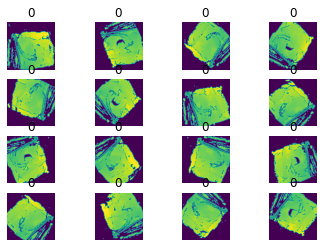

torch.Size([3, 224, 224])


In [11]:
# import data
sample_data_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.RandomRotation(180),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(), # also rescales
        transforms.Lambda(lambda x: torch.cat([x, x, x])),
    ])

sample_data_dir = 'data/FirstFrameDepthRGB_origData_prePT/p1'
sample_image_dataset = datasets.ImageFolder(sample_data_dir, sample_data_transform)
sample_dataloader = torch.utils.data.DataLoader(sample_image_dataset, batch_size=BATCH_SIZE, shuffle=True)
sample_dataset = len(sample_image_dataset)

samples, label = iter(sample_dataloader).next()
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i][0])
    plt.title(label[i].item())
    plt.axis('off')
plt.show()

print(samples[0].shape)

Fold: 0
noone_train: 11195, nurse_train: 1067
noone_val: 2437, nurse_val: 193

['noone', 'nurse']
Epoch 1/20
----------


100%|██████████| 767/767 [02:52<00:00,  4.44it/s]


train Loss: 0.6197 Acc: 0.7509


100%|██████████| 165/165 [00:20<00:00,  7.96it/s]


val Loss: 0.5513 Acc: 0.7202

Epoch 2/20
----------


100%|██████████| 767/767 [02:23<00:00,  5.34it/s]


train Loss: 0.5037 Acc: 0.8079


100%|██████████| 165/165 [00:14<00:00, 11.32it/s]


val Loss: 0.4269 Acc: 0.8395

Epoch 3/20
----------


100%|██████████| 767/767 [02:22<00:00,  5.37it/s]


train Loss: 0.4494 Acc: 0.8329


100%|██████████| 165/165 [00:14<00:00, 11.13it/s]


val Loss: 0.3955 Acc: 0.9582

Epoch 4/20
----------


100%|██████████| 767/767 [02:20<00:00,  5.45it/s]


train Loss: 0.4207 Acc: 0.8481


100%|██████████| 165/165 [00:14<00:00, 11.44it/s]


val Loss: 0.3727 Acc: 0.9620

Epoch 5/20
----------


100%|██████████| 767/767 [02:21<00:00,  5.41it/s]


train Loss: 0.4135 Acc: 0.8513


100%|██████████| 165/165 [00:14<00:00, 11.54it/s]


val Loss: 0.3726 Acc: 0.9616

Epoch 6/20
----------


100%|██████████| 767/767 [02:21<00:00,  5.40it/s]


train Loss: 0.3948 Acc: 0.8621


100%|██████████| 165/165 [00:14<00:00, 11.17it/s]


val Loss: 0.3514 Acc: 0.9646

Epoch 7/20
----------


100%|██████████| 767/767 [02:22<00:00,  5.38it/s]


train Loss: 0.3823 Acc: 0.8647


100%|██████████| 165/165 [00:14<00:00, 11.42it/s]


val Loss: 0.3775 Acc: 0.9624

Epoch 8/20
----------


100%|██████████| 767/767 [02:21<00:00,  5.43it/s]


train Loss: 0.3803 Acc: 0.8694


100%|██████████| 165/165 [00:14<00:00, 11.51it/s]


val Loss: 0.3264 Acc: 0.9665

Epoch 9/20
----------


100%|██████████| 767/767 [02:21<00:00,  5.43it/s]


train Loss: 0.3598 Acc: 0.8725


100%|██████████| 165/165 [00:14<00:00, 11.50it/s]


val Loss: 0.3318 Acc: 0.9673

Epoch 10/20
----------


100%|██████████| 767/767 [02:21<00:00,  5.44it/s]


train Loss: 0.3528 Acc: 0.8740


100%|██████████| 165/165 [00:14<00:00, 11.53it/s]


val Loss: 0.4056 Acc: 0.9559

Epoch 11/20
----------


100%|██████████| 767/767 [02:20<00:00,  5.45it/s]


train Loss: 0.3445 Acc: 0.8817


100%|██████████| 165/165 [00:14<00:00, 11.57it/s]


val Loss: 0.3241 Acc: 0.9684

Epoch 12/20
----------


100%|██████████| 767/767 [02:20<00:00,  5.44it/s]


train Loss: 0.3458 Acc: 0.8808


100%|██████████| 165/165 [00:14<00:00, 11.49it/s]


val Loss: 0.3465 Acc: 0.9662

Epoch 13/20
----------


100%|██████████| 767/767 [02:20<00:00,  5.45it/s]


train Loss: 0.3276 Acc: 0.8834


100%|██████████| 165/165 [00:14<00:00, 11.52it/s]


val Loss: 0.3219 Acc: 0.9715

Epoch 14/20
----------


100%|██████████| 767/767 [02:22<00:00,  5.39it/s]


train Loss: 0.3379 Acc: 0.8869


100%|██████████| 165/165 [00:14<00:00, 11.23it/s]


val Loss: 0.3195 Acc: 0.9692

Epoch 15/20
----------


100%|██████████| 767/767 [02:22<00:00,  5.37it/s]


train Loss: 0.3164 Acc: 0.8897


100%|██████████| 165/165 [00:14<00:00, 11.20it/s]


val Loss: 0.3172 Acc: 0.9707

Epoch 16/20
----------


100%|██████████| 767/767 [02:21<00:00,  5.40it/s]


train Loss: 0.3158 Acc: 0.8919


100%|██████████| 165/165 [00:14<00:00, 11.74it/s]


val Loss: 0.3204 Acc: 0.9700

Epoch 17/20
----------


100%|██████████| 767/767 [02:21<00:00,  5.44it/s]


train Loss: 0.3061 Acc: 0.8984


100%|██████████| 165/165 [00:14<00:00, 11.46it/s]


val Loss: 0.3244 Acc: 0.9707

Epoch 18/20
----------


100%|██████████| 767/767 [02:20<00:00,  5.44it/s]


train Loss: 0.3045 Acc: 0.8980


100%|██████████| 165/165 [00:14<00:00, 11.55it/s]


val Loss: 0.2729 Acc: 0.9707

Epoch 19/20
----------


100%|██████████| 767/767 [02:21<00:00,  5.43it/s]


train Loss: 0.2986 Acc: 0.9017


100%|██████████| 165/165 [00:14<00:00, 11.50it/s]


val Loss: 0.3171 Acc: 0.9715

Epoch 20/20
----------


100%|██████████| 767/767 [02:20<00:00,  5.44it/s]


train Loss: 0.2922 Acc: 0.9052


100%|██████████| 165/165 [00:14<00:00, 11.45it/s]


val Loss: 0.2590 Acc: 0.9665

Training complete in 52m 40s
Best val Acc: 0.971483


100%|██████████| 165/165 [00:14<00:00, 11.49it/s]


TP: 129, FP: 11, FN: 64, TN: 2426
Sens: 0.6683937823834197, Spec: 0.9954862535904802, Prec: 0.9214285714285714, Acc: 0.9714828897338403, F1: 0.7747747747747747

Fold: 1
noone_train: 11076, nurse_train: 944
noone_val: 2556, nurse_val: 316

['noone', 'nurse']
Epoch 1/20
----------


100%|██████████| 752/752 [02:44<00:00,  4.57it/s]


train Loss: 0.5993 Acc: 0.7828


100%|██████████| 180/180 [00:22<00:00,  8.06it/s]


val Loss: 0.5473 Acc: 0.9077

Epoch 2/20
----------


100%|██████████| 752/752 [02:18<00:00,  5.44it/s]


train Loss: 0.4779 Acc: 0.8372


100%|██████████| 180/180 [00:15<00:00, 11.45it/s]


val Loss: 0.4593 Acc: 0.7441

Epoch 3/20
----------


100%|██████████| 752/752 [02:15<00:00,  5.54it/s]


train Loss: 0.4393 Acc: 0.8579


100%|██████████| 180/180 [00:15<00:00, 11.80it/s]


val Loss: 0.4430 Acc: 0.8531

Epoch 4/20
----------


100%|██████████| 752/752 [02:15<00:00,  5.54it/s]


train Loss: 0.4021 Acc: 0.8691


100%|██████████| 180/180 [00:15<00:00, 11.48it/s]


val Loss: 0.4241 Acc: 0.8137

Epoch 5/20
----------


100%|██████████| 752/752 [02:16<00:00,  5.53it/s]


train Loss: 0.3919 Acc: 0.8709


100%|██████████| 180/180 [00:15<00:00, 11.50it/s]


val Loss: 0.4039 Acc: 0.7960

Epoch 6/20
----------


100%|██████████| 752/752 [02:18<00:00,  5.43it/s]


train Loss: 0.3776 Acc: 0.8798


100%|██████████| 180/180 [00:15<00:00, 11.43it/s]


val Loss: 0.4060 Acc: 0.8492

Epoch 7/20
----------


100%|██████████| 752/752 [02:16<00:00,  5.51it/s]


train Loss: 0.3611 Acc: 0.8821


100%|██████████| 180/180 [00:15<00:00, 11.60it/s]


val Loss: 0.4045 Acc: 0.8757

Epoch 8/20
----------


100%|██████████| 752/752 [02:16<00:00,  5.52it/s]


train Loss: 0.3512 Acc: 0.8878


100%|██████████| 180/180 [00:15<00:00, 11.56it/s]


val Loss: 0.4079 Acc: 0.7726

Epoch 9/20
----------


100%|██████████| 752/752 [02:16<00:00,  5.51it/s]


train Loss: 0.3388 Acc: 0.8900


100%|██████████| 180/180 [00:15<00:00, 11.57it/s]


val Loss: 0.4179 Acc: 0.7674

Epoch 10/20
----------


100%|██████████| 752/752 [02:15<00:00,  5.55it/s]


train Loss: 0.3274 Acc: 0.8966


100%|██████████| 180/180 [00:15<00:00, 11.59it/s]


val Loss: 0.4452 Acc: 0.6560

Epoch 11/20
----------


100%|██████████| 752/752 [02:15<00:00,  5.53it/s]


train Loss: 0.3196 Acc: 0.8963


100%|██████████| 180/180 [00:15<00:00, 11.50it/s]


val Loss: 0.4519 Acc: 0.6466

Epoch 12/20
----------


100%|██████████| 752/752 [02:15<00:00,  5.55it/s]


train Loss: 0.3076 Acc: 0.9027


100%|██████████| 180/180 [00:15<00:00, 11.55it/s]


val Loss: 0.4491 Acc: 0.6678

Epoch 13/20
----------


100%|██████████| 752/752 [02:16<00:00,  5.50it/s]


train Loss: 0.3166 Acc: 0.9003


100%|██████████| 180/180 [00:15<00:00, 11.57it/s]


val Loss: 0.4346 Acc: 0.6898

Epoch 14/20
----------


100%|██████████| 752/752 [02:16<00:00,  5.50it/s]


train Loss: 0.3030 Acc: 0.9046


100%|██████████| 180/180 [00:16<00:00, 11.22it/s]


val Loss: 0.4389 Acc: 0.7009

Epoch 15/20
----------


100%|██████████| 752/752 [02:17<00:00,  5.46it/s]


train Loss: 0.2985 Acc: 0.9073


100%|██████████| 180/180 [00:15<00:00, 11.55it/s]


val Loss: 0.4613 Acc: 0.6330

Epoch 16/20
----------


100%|██████████| 752/752 [02:17<00:00,  5.49it/s]


train Loss: 0.2892 Acc: 0.9087


100%|██████████| 180/180 [00:16<00:00, 11.20it/s]


val Loss: 0.4749 Acc: 0.6302

Epoch 17/20
----------


100%|██████████| 752/752 [02:17<00:00,  5.47it/s]


train Loss: 0.2824 Acc: 0.9090


100%|██████████| 180/180 [00:15<00:00, 11.46it/s]


val Loss: 0.4747 Acc: 0.6222

Epoch 18/20
----------


100%|██████████| 752/752 [02:17<00:00,  5.48it/s]


train Loss: 0.2846 Acc: 0.9119


100%|██████████| 180/180 [00:16<00:00, 11.20it/s]


val Loss: 0.4671 Acc: 0.6633

Epoch 19/20
----------


100%|██████████| 752/752 [02:18<00:00,  5.42it/s]


train Loss: 0.2785 Acc: 0.9153


100%|██████████| 180/180 [00:16<00:00, 11.23it/s]


val Loss: 0.4562 Acc: 0.6442

Epoch 20/20
----------


100%|██████████| 752/752 [02:18<00:00,  5.43it/s]


train Loss: 0.2747 Acc: 0.9187


100%|██████████| 180/180 [00:16<00:00, 11.18it/s]


val Loss: 0.4815 Acc: 0.6309

Training complete in 51m 27s
Best val Acc: 0.907730


100%|██████████| 180/180 [00:15<00:00, 11.56it/s]


TP: 189, FP: 138, FN: 127, TN: 2418
Sens: 0.5981012658227848, Spec: 0.9460093896713615, Prec: 0.5779816513761468, Acc: 0.9077298050139275, F1: 0.5878693623639192

Fold: 2
noone_train: 11105, nurse_train: 958
noone_val: 2527, nurse_val: 302

['noone', 'nurse']
Epoch 1/20
----------


100%|██████████| 754/754 [02:43<00:00,  4.62it/s]


train Loss: 0.6003 Acc: 0.7877


100%|██████████| 177/177 [00:21<00:00,  8.23it/s]


val Loss: 0.5513 Acc: 0.7614

Epoch 2/20
----------


100%|██████████| 754/754 [02:13<00:00,  5.67it/s]


train Loss: 0.4828 Acc: 0.8436


100%|██████████| 177/177 [00:14<00:00, 11.89it/s]


val Loss: 0.5126 Acc: 0.7879

Epoch 3/20
----------


100%|██████████| 754/754 [02:13<00:00,  5.66it/s]


train Loss: 0.4268 Acc: 0.8582


100%|██████████| 177/177 [00:14<00:00, 11.82it/s]


val Loss: 0.5012 Acc: 0.7886

Epoch 4/20
----------


100%|██████████| 754/754 [02:13<00:00,  5.66it/s]


train Loss: 0.3948 Acc: 0.8755


100%|██████████| 177/177 [00:14<00:00, 11.93it/s]


val Loss: 0.5111 Acc: 0.7893

Epoch 5/20
----------


100%|██████████| 754/754 [02:12<00:00,  5.68it/s]


train Loss: 0.3838 Acc: 0.8832


100%|██████████| 177/177 [00:14<00:00, 11.90it/s]


val Loss: 0.5110 Acc: 0.7890

Epoch 6/20
----------


100%|██████████| 754/754 [02:15<00:00,  5.57it/s]


train Loss: 0.3698 Acc: 0.8831


100%|██████████| 177/177 [00:15<00:00, 11.52it/s]


val Loss: 0.5067 Acc: 0.7932

Epoch 7/20
----------


100%|██████████| 754/754 [02:17<00:00,  5.47it/s]


train Loss: 0.3586 Acc: 0.8927


100%|██████████| 177/177 [00:15<00:00, 11.36it/s]


val Loss: 0.4942 Acc: 0.7943

Epoch 8/20
----------


100%|██████████| 754/754 [02:17<00:00,  5.49it/s]


train Loss: 0.3472 Acc: 0.8988


100%|██████████| 177/177 [00:15<00:00, 11.51it/s]


val Loss: 0.5063 Acc: 0.7950

Epoch 9/20
----------


100%|██████████| 754/754 [02:17<00:00,  5.48it/s]


train Loss: 0.3375 Acc: 0.8984


100%|██████████| 177/177 [00:15<00:00, 11.15it/s]


val Loss: 0.5026 Acc: 0.7932

Epoch 10/20
----------


100%|██████████| 754/754 [02:18<00:00,  5.43it/s]


train Loss: 0.3299 Acc: 0.9018


100%|██████████| 177/177 [00:15<00:00, 11.21it/s]


val Loss: 0.5052 Acc: 0.7960

Epoch 11/20
----------


100%|██████████| 754/754 [02:18<00:00,  5.43it/s]


train Loss: 0.3133 Acc: 0.9084


100%|██████████| 177/177 [00:15<00:00, 11.25it/s]


val Loss: 0.5219 Acc: 0.7957

Epoch 12/20
----------


100%|██████████| 754/754 [02:15<00:00,  5.56it/s]


train Loss: 0.3119 Acc: 0.9090


100%|██████████| 177/177 [00:15<00:00, 11.43it/s]


val Loss: 0.5252 Acc: 0.7932

Epoch 13/20
----------


100%|██████████| 754/754 [02:14<00:00,  5.60it/s]


train Loss: 0.3057 Acc: 0.9151


100%|██████████| 177/177 [00:14<00:00, 11.85it/s]


val Loss: 0.5012 Acc: 0.7950

Epoch 14/20
----------


100%|██████████| 754/754 [02:13<00:00,  5.65it/s]


train Loss: 0.2986 Acc: 0.9151


100%|██████████| 177/177 [00:15<00:00, 11.77it/s]


val Loss: 0.4984 Acc: 0.7967

Epoch 15/20
----------


100%|██████████| 754/754 [02:13<00:00,  5.67it/s]


train Loss: 0.2973 Acc: 0.9138


100%|██████████| 177/177 [00:14<00:00, 11.82it/s]


val Loss: 0.5286 Acc: 0.7967

Epoch 16/20
----------


100%|██████████| 754/754 [02:16<00:00,  5.52it/s]


train Loss: 0.3035 Acc: 0.9156


100%|██████████| 177/177 [00:15<00:00, 11.41it/s]


val Loss: 0.5109 Acc: 0.7950

Epoch 17/20
----------


100%|██████████| 754/754 [02:17<00:00,  5.48it/s]


train Loss: 0.2749 Acc: 0.9243


100%|██████████| 177/177 [00:15<00:00, 11.48it/s]


val Loss: 0.5155 Acc: 0.7985

Epoch 18/20
----------


100%|██████████| 754/754 [02:17<00:00,  5.49it/s]


train Loss: 0.2910 Acc: 0.9207


100%|██████████| 177/177 [00:15<00:00, 11.46it/s]


val Loss: 0.5254 Acc: 0.7967

Epoch 19/20
----------


100%|██████████| 754/754 [02:18<00:00,  5.46it/s]


train Loss: 0.2698 Acc: 0.9245


100%|██████████| 177/177 [00:15<00:00, 11.26it/s]


val Loss: 0.5458 Acc: 0.7975

Epoch 20/20
----------


100%|██████████| 754/754 [02:18<00:00,  5.43it/s]


train Loss: 0.2787 Acc: 0.9211


100%|██████████| 177/177 [00:15<00:00, 11.17it/s]


val Loss: 0.5409 Acc: 0.7975

Training complete in 50m 60s
Best val Acc: 0.798515


100%|██████████| 177/177 [00:15<00:00, 11.25it/s]


TP: 248, FP: 516, FN: 54, TN: 2011
Sens: 0.8211920529801324, Spec: 0.7958053027305105, Prec: 0.32460732984293195, Acc: 0.7985153764581124, F1: 0.4652908067542214

Fold: 3
noone_train: 10368, nurse_train: 1055
noone_val: 3264, nurse_val: 205

['noone', 'nurse']
Epoch 1/20
----------


100%|██████████| 714/714 [02:36<00:00,  4.56it/s]


train Loss: 0.6123 Acc: 0.7249


100%|██████████| 217/217 [00:26<00:00,  8.20it/s]


val Loss: 0.5260 Acc: 0.9524

Epoch 2/20
----------


100%|██████████| 714/714 [02:07<00:00,  5.60it/s]


train Loss: 0.5081 Acc: 0.8043


100%|██████████| 217/217 [00:18<00:00, 11.67it/s]


val Loss: 0.5156 Acc: 0.6852

Epoch 3/20
----------


100%|██████████| 714/714 [02:06<00:00,  5.64it/s]


train Loss: 0.4558 Acc: 0.8284


100%|██████████| 217/217 [00:18<00:00, 11.96it/s]


val Loss: 0.4841 Acc: 0.7207

Epoch 4/20
----------


100%|██████████| 714/714 [02:06<00:00,  5.65it/s]


train Loss: 0.4304 Acc: 0.8396


100%|██████████| 217/217 [00:18<00:00, 11.95it/s]


val Loss: 0.4847 Acc: 0.6763

Epoch 5/20
----------


100%|██████████| 714/714 [02:06<00:00,  5.65it/s]


train Loss: 0.4043 Acc: 0.8523


100%|██████████| 217/217 [00:18<00:00, 11.89it/s]


val Loss: 0.5337 Acc: 0.5924

Epoch 6/20
----------


100%|██████████| 714/714 [02:06<00:00,  5.64it/s]


train Loss: 0.3841 Acc: 0.8587


100%|██████████| 217/217 [00:18<00:00, 11.98it/s]


val Loss: 0.5108 Acc: 0.6276

Epoch 7/20
----------


100%|██████████| 714/714 [02:06<00:00,  5.66it/s]


train Loss: 0.3770 Acc: 0.8616


100%|██████████| 217/217 [00:18<00:00, 11.93it/s]


val Loss: 0.5680 Acc: 0.5517

Epoch 8/20
----------


100%|██████████| 714/714 [02:06<00:00,  5.66it/s]


train Loss: 0.3586 Acc: 0.8638


100%|██████████| 217/217 [00:18<00:00, 11.98it/s]


val Loss: 0.5154 Acc: 0.6284

Epoch 9/20
----------


100%|██████████| 714/714 [02:07<00:00,  5.60it/s]


train Loss: 0.3522 Acc: 0.8688


100%|██████████| 217/217 [00:18<00:00, 11.55it/s]


val Loss: 0.4556 Acc: 0.7939

Epoch 10/20
----------


100%|██████████| 714/714 [02:08<00:00,  5.58it/s]


train Loss: 0.3460 Acc: 0.8738


100%|██████████| 217/217 [00:18<00:00, 11.63it/s]


val Loss: 0.4561 Acc: 0.8224

Epoch 11/20
----------


100%|██████████| 714/714 [02:09<00:00,  5.53it/s]


train Loss: 0.3434 Acc: 0.8703


100%|██████████| 217/217 [00:18<00:00, 11.60it/s]


val Loss: 0.5231 Acc: 0.6463

Epoch 12/20
----------


100%|██████████| 714/714 [02:09<00:00,  5.50it/s]


train Loss: 0.3381 Acc: 0.8760


100%|██████████| 217/217 [00:18<00:00, 11.69it/s]


val Loss: 0.4009 Acc: 0.8740

Epoch 13/20
----------


100%|██████████| 714/714 [02:10<00:00,  5.45it/s]


train Loss: 0.3219 Acc: 0.8796


100%|██████████| 217/217 [00:18<00:00, 11.56it/s]


val Loss: 0.4379 Acc: 0.8224

Epoch 14/20
----------


100%|██████████| 714/714 [02:10<00:00,  5.46it/s]


train Loss: 0.3226 Acc: 0.8809


100%|██████████| 217/217 [00:18<00:00, 11.58it/s]


val Loss: 0.4774 Acc: 0.7426

Epoch 15/20
----------


100%|██████████| 714/714 [02:10<00:00,  5.48it/s]


train Loss: 0.3094 Acc: 0.8795


100%|██████████| 217/217 [00:18<00:00, 11.59it/s]


val Loss: 0.4254 Acc: 0.8002

Epoch 16/20
----------


100%|██████████| 714/714 [02:10<00:00,  5.49it/s]


train Loss: 0.3035 Acc: 0.8871


100%|██████████| 217/217 [00:18<00:00, 11.58it/s]


val Loss: 0.4577 Acc: 0.8611

Epoch 17/20
----------


100%|██████████| 714/714 [02:10<00:00,  5.46it/s]


train Loss: 0.3006 Acc: 0.8900


100%|██████████| 217/217 [00:19<00:00, 11.24it/s]


val Loss: 0.4011 Acc: 0.8662

Epoch 18/20
----------


100%|██████████| 714/714 [02:08<00:00,  5.55it/s]


train Loss: 0.2936 Acc: 0.8911


100%|██████████| 217/217 [00:18<00:00, 11.64it/s]


val Loss: 0.3860 Acc: 0.8737

Epoch 19/20
----------


100%|██████████| 714/714 [02:08<00:00,  5.58it/s]


train Loss: 0.2859 Acc: 0.8901


100%|██████████| 217/217 [00:18<00:00, 11.62it/s]


val Loss: 0.3871 Acc: 0.8619

Epoch 20/20
----------


100%|██████████| 714/714 [02:07<00:00,  5.58it/s]


train Loss: 0.2819 Acc: 0.8956


100%|██████████| 217/217 [00:18<00:00, 11.62it/s]


val Loss: 0.4299 Acc: 0.8106

Training complete in 49m 34s
Best val Acc: 0.952436


100%|██████████| 217/217 [00:18<00:00, 11.76it/s]


TP: 96, FP: 56, FN: 109, TN: 3208
Sens: 0.4682926829268293, Spec: 0.9828431372549019, Prec: 0.631578947368421, Acc: 0.952435860478524, F1: 0.5378151260504201

Fold: 4
noone_train: 10784, nurse_train: 1016
noone_val: 2848, nurse_val: 244

['noone', 'nurse']
Epoch 1/20
----------


100%|██████████| 738/738 [02:39<00:00,  4.64it/s]


train Loss: 0.6464 Acc: 0.7660


100%|██████████| 194/194 [00:22<00:00,  8.61it/s]


val Loss: 0.5700 Acc: 0.9314

Epoch 2/20
----------


100%|██████████| 738/738 [02:12<00:00,  5.59it/s]


train Loss: 0.5262 Acc: 0.7948


100%|██████████| 194/194 [00:16<00:00, 11.94it/s]


val Loss: 0.5192 Acc: 0.9405

Epoch 3/20
----------


100%|██████████| 738/738 [02:12<00:00,  5.57it/s]


train Loss: 0.4417 Acc: 0.8405


100%|██████████| 194/194 [00:16<00:00, 11.84it/s]


val Loss: 0.5642 Acc: 0.9376

Epoch 4/20
----------


100%|██████████| 738/738 [02:12<00:00,  5.57it/s]


train Loss: 0.4127 Acc: 0.8509


100%|██████████| 194/194 [00:16<00:00, 11.82it/s]


val Loss: 0.5454 Acc: 0.9237

Epoch 5/20
----------


100%|██████████| 738/738 [02:12<00:00,  5.56it/s]


train Loss: 0.3831 Acc: 0.8621


100%|██████████| 194/194 [00:16<00:00, 11.82it/s]


val Loss: 0.6372 Acc: 0.9227

Epoch 6/20
----------


100%|██████████| 738/738 [02:10<00:00,  5.64it/s]


train Loss: 0.3858 Acc: 0.8560


100%|██████████| 194/194 [00:16<00:00, 12.09it/s]


val Loss: 0.6015 Acc: 0.9237

Epoch 7/20
----------


100%|██████████| 738/738 [02:10<00:00,  5.64it/s]


train Loss: 0.3741 Acc: 0.8702


100%|██████████| 194/194 [00:15<00:00, 12.14it/s]


val Loss: 0.5809 Acc: 0.9188

Epoch 8/20
----------


100%|██████████| 738/738 [02:10<00:00,  5.64it/s]


train Loss: 0.3604 Acc: 0.8753


100%|██████████| 194/194 [00:15<00:00, 12.16it/s]


val Loss: 0.5344 Acc: 0.9156

Epoch 9/20
----------


100%|██████████| 738/738 [02:10<00:00,  5.63it/s]


train Loss: 0.3522 Acc: 0.8741


100%|██████████| 194/194 [00:16<00:00, 11.90it/s]


val Loss: 0.5807 Acc: 0.9217

Epoch 10/20
----------


100%|██████████| 738/738 [02:12<00:00,  5.58it/s]


train Loss: 0.3434 Acc: 0.8820


100%|██████████| 194/194 [00:16<00:00, 11.93it/s]


val Loss: 0.5595 Acc: 0.9182

Epoch 11/20
----------


100%|██████████| 738/738 [02:12<00:00,  5.56it/s]


train Loss: 0.3366 Acc: 0.8846


100%|██████████| 194/194 [00:16<00:00, 11.75it/s]


val Loss: 0.5709 Acc: 0.9182

Epoch 12/20
----------


100%|██████████| 738/738 [02:12<00:00,  5.55it/s]


train Loss: 0.3352 Acc: 0.8820


100%|██████████| 194/194 [00:16<00:00, 11.83it/s]


val Loss: 0.6518 Acc: 0.9250

Epoch 13/20
----------


100%|██████████| 738/738 [02:12<00:00,  5.57it/s]


train Loss: 0.3182 Acc: 0.8925


100%|██████████| 194/194 [00:16<00:00, 11.93it/s]


val Loss: 0.6315 Acc: 0.9240

Epoch 14/20
----------


100%|██████████| 738/738 [02:11<00:00,  5.60it/s]


train Loss: 0.3127 Acc: 0.8941


100%|██████████| 194/194 [00:16<00:00, 11.90it/s]


val Loss: 0.6237 Acc: 0.9221

Epoch 15/20
----------


100%|██████████| 738/738 [02:11<00:00,  5.62it/s]


train Loss: 0.3136 Acc: 0.8900


100%|██████████| 194/194 [00:16<00:00, 12.06it/s]


val Loss: 0.5359 Acc: 0.9140

Epoch 16/20
----------


100%|██████████| 738/738 [02:11<00:00,  5.62it/s]


train Loss: 0.3123 Acc: 0.8931


100%|██████████| 194/194 [00:16<00:00, 12.09it/s]


val Loss: 0.6646 Acc: 0.9234

Epoch 17/20
----------


100%|██████████| 738/738 [02:11<00:00,  5.62it/s]


train Loss: 0.3009 Acc: 0.8979


100%|██████████| 194/194 [00:16<00:00, 11.91it/s]


val Loss: 0.6473 Acc: 0.9237

Epoch 18/20
----------


100%|██████████| 738/738 [02:11<00:00,  5.61it/s]


train Loss: 0.2967 Acc: 0.8984


100%|██████████| 194/194 [00:16<00:00, 12.01it/s]


val Loss: 0.6865 Acc: 0.9234

Epoch 19/20
----------


100%|██████████| 738/738 [02:11<00:00,  5.61it/s]


train Loss: 0.3012 Acc: 0.9002


100%|██████████| 194/194 [00:16<00:00, 12.05it/s]


val Loss: 0.5767 Acc: 0.9153

Epoch 20/20
----------


100%|██████████| 738/738 [02:11<00:00,  5.63it/s]


train Loss: 0.3009 Acc: 0.8986


100%|██████████| 194/194 [00:15<00:00, 12.13it/s]


val Loss: 0.5915 Acc: 0.9227

Training complete in 49m 54s
Best val Acc: 0.940492


100%|██████████| 194/194 [00:16<00:00, 11.93it/s]

TP: 76, FP: 16, FN: 168, TN: 2832
Sens: 0.3114754098360656, Spec: 0.9943820224719101, Prec: 0.8260869565217391, Acc: 0.9404915912031048, F1: 0.4523809523809524



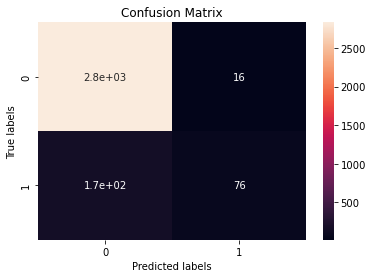

In [12]:
all_train_idx = np.array([
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    ])
all_val_idx = (all_train_idx == 0).astype('int32')

totalRuns = 1
runNum = 1

for currRun in range(int(totalRuns)):
    foldNum = 0
    runSaveNum = int(runNum) + int(currRun)
    for train_index, val_index in zip(all_train_idx, all_val_idx):
        train_idx = train_index.nonzero()[0]
        val_idx = val_index.nonzero()[0]

        print(f'Fold: {foldNum}')

        # Select the current folds for training and validation
        noone_train = []
        nurse_train = []
        noone_val = []
        nurse_val = []
        for i in train_idx:
            noone_train += all_noone_list[i]
            nurse_train += all_nurse_list[i]
        for i in val_idx:
            noone_val += all_noone_list[i]
            nurse_val += all_nurse_list[i]

        # Move images to training and testing folders
        noone_train, nurse_train, noone_val, nurse_val = prepFiles(noone_train, nurse_train, noone_val, nurse_val)

        print(f"noone_train: {len(noone_train)}, nurse_train: {len(nurse_train)}")
        print(f"noone_val: {len(noone_val)}, nurse_val: {len(nurse_val)}\n")

        weight_for_0 = (1 / (len(noone_train) + len(noone_val))) * ((len(nurse_train) + len(nurse_val) + len(noone_train) + len(noone_val)) / 2.0)
        weight_for_1 = (1 / (len(nurse_train) + len(nurse_val))) * ((len(nurse_train) + len(nurse_val) + len(noone_train) + len(noone_val)) / 2.0)
        CLASS_WEIGHT = torch.tensor([weight_for_0, weight_for_1], device=device)

        # import data
        sets = ['train', 'val']
        image_datasets = {x: datasets.ImageFolder(os.path.join(ROOT_DATA_DIR, x), data_transforms[x]) for x in sets}
        dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True) for x in sets}
        dataset_sizes = {x: len(image_datasets[x]) for x in sets}

        class_names = image_datasets['train'].classes
        print(class_names)

        ###
        # train everything

        model = create_model(finetuning=FINETUNING)

        model.to(device)

        criterion = nn.CrossEntropyLoss(weight=CLASS_WEIGHT)
        optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)


        model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=20)

        foldNum += 1

        modelPath = "savedModels/" + BASE_MODEL_NAME + "_run" + str(runSaveNum) + "_fold" + str(foldNum) + ".pth"
        torch.save(model.state_dict(), modelPath)

        evalModel(model, dataloaders['val'])